# Adversarial Variational Bayes in Pytorch

In the previous post, we implemented a Variational Autoencoder, and pointed out a few problems. The overlap between classes was one of the key problems. The normality assumption is also perhaps somewhat constraining.

In this post, I implement the recent paper [Adversarial Variational Bayes](https://arxiv.org/pdf/1701.04722.pdf), in Pytorch. This addresses some of the issues with VAEs, and also provides some interesting links to GANs, the other popular approach to generative modelling.

## Theory

Before diving in, if you are not familiar with VAEs, I suggest you take some time to recap my [previous post](https://chrisorm.github.io/VI-to-VAE.html) on the theory of VAEs. 

The main modification proposed by the [AVB paper](https://arxiv.org/pdf/1701.04722.pdf), is to change the encoder from being a parameterized Gaussian to being a fully implicit distribution. In a vanilla VAE, the encoder network takes a data point, x, as input and outputs the mean and variance of a normal distribution. We then used the reparameterization trick on standard normal samples to sample values of the latent variables.

The first modification is that instead of outputting a mean and variance, the encoder now returns a z value directly. The inputs are now data points, x, and standard Gaussian noise. So our encoder network learns how to incorporate the random noise to generate a sample from the approximate posterior directly. 

This is most easily shown by figure 2 in the original paper.

### Implicit Likelihood Ratio

Once we have made the above change, we have a problem. The ELBO:

$max_{\phi}max_{\theta} \ E_{p_{D}}[ \mathcal{L}] = max_{\phi, \theta} E_{p_{D}}[E_{q}[log \ P_{\theta}(X \mid Z) + log \ P_{\theta}(Z) - log \ q_{\phi}(Z \mid X)]] $

contains probabilities under the approximate posterior, q. Now we have an implicit model for q, we can't evaluate the probability of a sample. In order to deal with this problem, we use the idea from [Learning in Implicit Generative Models](https://arxiv.org/abs/1610.03483), covered in a [previous post](https://chrisorm.github.io/GM-Disc-as-ratios.html). The idea is to use a discriminator to approximate the log ratio of q and the prior.

We introduce a second network, $T(x,z)$, which outputs a single value for each sample. If we label the samples from the posterior as class 1, and from the prior as class 0, we can then pass the output of T through a sigmoid, and then train it using binary cross entropy, in exactly the same way as with my previous post on [Discriminators as likelihood ratios](https://chrisorm.github.io/GM-Disc-as-ratios.html). In this case, the output of T (without the sigmoid) are the logits, which at optimality of the discriminator is the ratio of the two distributions. We can therefor substitute the output of T directly for the ratio term in the ELBO, $log \ p(Z) - log \ q_{\phi}(Z\mid X) $.

This gives us two loss functions that we optimise in an iterative process. The discriminator is trained by minimising the binary cross entropy, and the encoder and decoder is trained by maximising the ELBO, but with the discriminator's estimate in place of an analytical $log \ p(Z) - log \ q_{\phi}(Z\mid X) $. 

$max \ \mathcal{L_{D}} = E_{P_{D}}( E_{q(z \mid x)}[log \ \sigma (T(X, Z))] + E_{p(z)}[log \ 1 - \sigma (T(X, Z))] )$

$max \ \mathcal{L_{G}} =   E_{p_{D}}[E_{q}[log \ P_{\theta}(X \mid Z) - T(X, Z)]] $

## In practice

I continue with the example I used in the VAE post, the toy example that is included in the post. 

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np

In [2]:
representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 500
gen_hidden_size = 200
enc_hidden_size = 200
disc_hidden_size = 200

In [3]:
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

Some example data points:

In [4]:
print(x[[10, 58 ,610, 790, 1123, 1258, 1506, 1988]])

[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.gen_l1 = torch.nn.Linear(representation_size, gen_hidden_size)
        self.gen_l2 = torch.nn.Linear(gen_hidden_size, input_size)
        
        self.enc_l1 = torch.nn.Linear(input_size+representation_size, 
                                      enc_hidden_size)
        self.enc_l2 = torch.nn.Linear(enc_hidden_size, representation_size)
        
        self.disc_l1 = torch.nn.Linear(input_size+representation_size, 
                                       disc_hidden_size)
        self.disc_l2 = torch.nn.Linear(disc_hidden_size, 1)
        
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def sample_prior(self, s):
        if self.training:
            m = torch.zeros((s.data.shape[0], representation_size))
            std = torch.ones((s.data.shape[0], representation_size))
            d = Variable(torch.normal(m,std))
        else:
            d = Variable(torch.zeros((s.data.shape[0], representation_size)))
        
        return d
    
    def discriminator(self, x,z):
        i = torch.cat((x, z), dim=1)
        h = self.relu(self.disc_l1(i))
        return self.disc_l2(h)
    
    def sample_posterior(self, x):
        i = torch.cat((x, self.sample_prior(x)), dim=1)
        h = self.relu(self.enc_l1(i))
        return self.enc_l2(h)
    
    def decoder(self, z):
        i = self.relu(self.gen_l1(z))
        h = self.sigmoid(self.gen_l2(i))
        return h
    
    def forward(self, x):
        z_p = self.sample_prior(x)
        
        z_q = self.sample_posterior(x)
        log_d_prior = self.discriminator(x, z_p)
        log_d_posterior = self.discriminator(x, z_q)
        disc_loss = torch.mean(
            torch.nn.functional.binary_cross_entropy_with_logits(
            log_d_posterior, torch.ones_like(log_d_posterior)
        )
        + torch.nn.functional.binary_cross_entropy_with_logits(
            log_d_prior, torch.zeros_like(log_d_prior))
        )
        
        x_recon = self.decoder(z_q)
        recon_liklihood = -torch.nn.functional.binary_cross_entropy(
                                                x_recon, x)*x.data.shape[0]
        
        gen_loss = torch.mean(log_d_posterior)-torch.mean(recon_liklihood)
        
        return disc_loss, gen_loss

In [6]:
model = VAE()

In [7]:
disc_params = []
gen_params = []
for name, param in model.named_parameters():
    
    if 'disc' in name:
        
        disc_params.append(param)
    else:
        gen_params.append(param)

In [8]:
disc_optimizer = torch.optim.Adam(disc_params, lr=1e-3)
gen_optimizer = torch.optim.Adam(gen_params, lr=1e-3)

In [9]:
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        
        
        discrim_loss, gen_loss= model(data)
        
        gen_optimizer.zero_grad()
        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()
        
        disc_optimizer.zero_grad()
        discrim_loss.backward(retain_graph=True)
        disc_optimizer.step()
        if (i % log_interval == 0) and (epoch % 1 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                discrim_loss.data[0] / len(data), gen_loss.data[0] / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


In [10]:
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/250500]	Loss: 0.002767	Loss: 0.665143
Train Epoch: 1 [250000/250500]	Loss: 0.000456	Loss: 0.005928
====> Epoch: 1 done!
Train Epoch: 2 [0/250500]	Loss: 0.000511	Loss: 0.005995
Train Epoch: 2 [250000/250500]	Loss: 0.001044	Loss: 0.004739
====> Epoch: 2 done!
Train Epoch: 3 [0/250500]	Loss: 0.001039	Loss: 0.004568
Train Epoch: 3 [250000/250500]	Loss: 0.000926	Loss: 0.004154
====> Epoch: 3 done!
Train Epoch: 4 [0/250500]	Loss: 0.000915	Loss: 0.004528
Train Epoch: 4 [250000/250500]	Loss: 0.001076	Loss: 0.003867
====> Epoch: 4 done!
Train Epoch: 5 [0/250500]	Loss: 0.001025	Loss: 0.003856
Train Epoch: 5 [250000/250500]	Loss: 0.001121	Loss: 0.003561
====> Epoch: 5 done!
Train Epoch: 6 [0/250500]	Loss: 0.001205	Loss: 0.003342
Train Epoch: 6 [250000/250500]	Loss: 0.001148	Loss: 0.003481
====> Epoch: 6 done!
Train Epoch: 7 [0/250500]	Loss: 0.000997	Loss: 0.003723
Train Epoch: 7 [250000/250500]	Loss: 0.001250	Loss: 0.003150
====> Epoch: 7 done!
Train Epoch: 8 [0/250500]	Loss: 0.

In [11]:
data = Variable(torch.from_numpy(x), requires_grad=False)

model.train()
zs = model.sample_posterior(data).data.numpy()

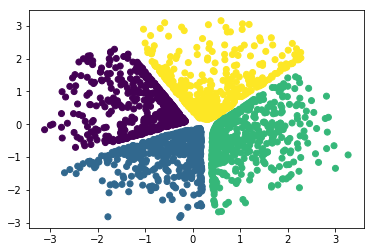

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 1], c=y)

The above plot generates stochastic z values. As we can see, this distribution is much clearer than the equivalent from VAEs. 

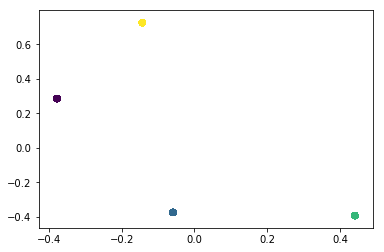

In [13]:
data = Variable(torch.from_numpy(x), requires_grad=False)
model.eval()
zs = model.sample_posterior(data).data.numpy()

plt.scatter(zs[:,0], zs[:, 1], c=y)

As this shows, it has learnt that their should be 4 means for the posterior, and positioned them far away from each other.

## Some example points

The output of the decoder is the Bernoulli probability that that element is 1. 

In [15]:
test_point = np.array([0.5, 0.6], dtype=np.float32).reshape(1,-1)
test_point = Variable(torch.from_numpy(test_point), requires_grad=False)
s = model.decoder(test_point)
s.data


 2.6369e-14  5.8558e-09  1.8340e-08  1.0000e+00
[torch.FloatTensor of size 1x4]

As the boundary is much sharper, it is normally clear for almost any point which class the latent variable corresponds to. If we pick a border point, the network has much lower probabilties.

In [16]:
test_point = np.array([0., 0.], dtype=np.float32).reshape(1,-1)
test_point = Variable(torch.from_numpy(test_point), requires_grad=False)
s = model.decoder(test_point)
s.data


 7.8847e-03  1.0944e-01  5.7596e-06  1.0726e-03
[torch.FloatTensor of size 1x4]

# Summary

In this post I have implemented the AVB algorithm in pytorch, and shown that it provides more intuitive latent codings than a vanilla VAE. This has been the first post to incorporate ideas from implicit generative modelling, and I hope to go over some more substantially theory in future posts.